# EE-655 Course Project
## Implementation of Complex YOLO Object Detector

## Installing the weights of the Pre-Trained complex ResNet-50
credits- Saurabh Yadav and Koteswar Sir for their work on FCNNs

In [1]:
!pip install gdown  

file_id = "1bot7pjGtxMbqsm2TvrprLMz8ym1Z2ufZ" 
!gdown --id $file_id -O resnet50_best.tar


/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1bot7pjGtxMbqsm2TvrprLMz8ym1Z2ufZ
From (redirected): https://drive.google.com/uc?id=1bot7pjGtxMbqsm2TvrprLMz8ym1Z2ufZ&confirm=t&uuid=9da15b3a-2612-4156-a89a-d4a82a29ff2a
To: /kaggle/working/resnet50_best.tar
100%|█████████████████████████████████████████| 410M/410M [00:03<00:00, 126MB/s]


## Installing the Dependencies 

In [3]:
import os
os.chdir( "/kaggle/working")

In [ ]:
-------------------------------------------

## Importing the complex ResNet50 architecture, Complex activations, loss, covolutions and the iHSV model from the FCNNs Repo

In [5]:
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Adding FCCNs repository to the Python path (update the path as per your Kaggle dataset)
sys.path.append("/kaggle/input/githubbb/FCCNs-main")

# Import custom transforms to convert images to complex (IHSV then complex)
from utils import ToHSV, ToComplex

# Import ResNet50 from the FCCNs repository; 
from networks import resnet50
from networks_new import ResNet, Bottleneck  # for backbone
import complexnn as comp   # provides ComplexConv2d etc.
import complex_activations as compact  # provides CPReLU, etc.


# Check for GPU:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Preparing the Training and Validation Dataset

In [6]:
# Define transforms for training and validation:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  
    ToHSV(),
    ToComplex()
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    ToHSV(),
    ToComplex()
])

train_dataset = torchvision.datasets.VOCDetection(
    root='.', image_set='train', download=True, transform=transform_train)

val_dataset = torchvision.datasets.VOCDetection(
    root='.', image_set='val', download=True, transform=transform_val)

# Custom collate function: images are uniform in size; targets (annotations) are returned as a list.
def detection_collate_fn(batch):
    images = []
    targets = []
    for img, ann in batch:
        images.append(img)
        targets.append(ann)  # Each ann is a dictionary with annotation info.
    images = torch.stack(images, 0)
    return images, targets

# Creating DataLoaders:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, collate_fn=detection_collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4, collate_fn=detection_collate_fn)

100%|██████████| 2.00G/2.00G [00:56<00:00, 35.5MB/s] 


Extracting ./VOCtrainval_11-May-2012.tar to .
Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar
Extracting ./VOCtrainval_11-May-2012.tar to .


## 1. Loading the Pre-Trained ResNet50 Backbone and modifying the final layers for detection head
## 2. Creating a Complex YOLO Style Detector Head


In [7]:
torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_backbone = resnet50(pretrained=False).to(device)  # Initializing backbone
# Loading pretrained weights from your checkpoint.
checkpoint_path = "/kaggle/working/resnet50_best.tar"
checkpoint = torch.load(checkpoint_path, map_location=device)
model_backbone.load_state_dict(checkpoint["state_dict"], strict=False)
print("Pretrained complex-valued ResNet50 loaded successfully!")
# Removing the classification head – set fc to Identity so that the output is a feature map.
if hasattr(model_backbone, 'fc'):
    model_backbone.fc = nn.Identity()
model_backbone = model_backbone.to(device)
model_backbone.eval()

def forward_backbone_without_pooling(self, x: torch.Tensor) -> torch.Tensor:
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.prelu(x)
    x = self.maxpool(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    # Do NOT apply avgpool or fc so that the spatial dimensions remain intact.
    return x

# Override the backbone's forward method:
model_backbone.forward = forward_backbone_without_pooling.__get__(model_backbone, type(model_backbone))


# --- YOLO-Style Detection Head ---
import complexnn as comp  # Import complex layers from FCCNs

# Building the Complex YOLO Head.
# This head takes the backbone’s output feature map and produces YOLO predictions.
# For each grid cell and each anchor, YOLO predicts:
# - 4 complex values: bounding box parameters, which we represent as two complex numbers:
#      z1 = x + i*y  and z2 = h + i*w.
# - 1 objectness score (real)
# - num_classes class scores (real)
#
# We design the head to output predictions over a grid (H, W) from the feature map.
# (In a full YOLO, anchor assignment and grid offsets are computed; here we implement a simplified variant.)
num_anchors = 3
num_classes = 20  # Pascal VOC has 20 classes

class ComplexYoloHead(nn.Module):
    def __init__(self, in_channels, num_anchors, num_classes):
        super(ComplexYoloHead, self).__init__()
        self.num_anchors = num_anchors
        self.num_classes = num_classes
        
        # A block of complex convolutions to process the feature map.
        self.conv_block = nn.Sequential(
            comp.ComplexConv2d(in_channels, 1024, kernel_size=3, padding=1),
            comp.ComplexNaiveBatchNorm2d(1024),
            compact.CPReLU(),  # Using complex activation
            comp.ComplexConv2d(1024, 512, kernel_size=3, padding=1),
            comp.ComplexNaiveBatchNorm2d(512),
            compact.CPReLU()
        )
        # Bounding box branch (complex output): outputs 4 values per anchor (as complex numbers).
        self.conv_bbox = comp.ComplexConv2d(512, num_anchors * 4, kernel_size=1)
        # Objectness branch (real output)
        self.conv_obj = nn.Conv2d(512, num_anchors * 1, kernel_size=1)
        # Classification branch (real output)
        self.conv_cls = nn.Conv2d(512, num_anchors * num_classes, kernel_size=1)
        
    def forward(self, x):
        """
        x: complex feature map of shape (B, in_channels, H, W)
        Returns:
            bbox_pred: complex tensor of shape (B, num_anchors*4, H, W)
            obj_pred: real tensor of shape (B, num_anchors, H, W)
            cls_pred: real tensor of shape (B, num_anchors*num_classes, H, W)
        """
        x = self.conv_block(x)  # Process feature map
        bbox_pred = self.conv_bbox(x)  # complex predictions
        obj_pred = self.conv_obj(x.real)  # use real part for objectness
        cls_pred = self.conv_cls(x.real)
        return bbox_pred, obj_pred, cls_pred

# Instantiate the YOLO head with the backbone output channels.
# The pretrained ResNet50 backbone (after removing fc) outputs a feature map with 2048 channels.
yolo_head = ComplexYoloHead(in_channels=2048, num_anchors=num_anchors, num_classes=num_classes).to(device)

# Combining Backbone and YOLO Head into a full detector.
class ComplexYoloDetector(nn.Module):
    def __init__(self, backbone, yolo_head):
        super(ComplexYoloDetector, self).__init__()
        self.backbone = backbone
        self.yolo_head = yolo_head
        
    def forward(self, x):
        # x: complex image tensor, e.g., (B, 3, 224, 224)
        features = self.backbone(x)  # Expected shape: (B, 2048, H, W)
        bbox_pred, obj_pred, cls_pred = self.yolo_head(features)
        return bbox_pred, obj_pred, cls_pred

detector = ComplexYoloDetector(model_backbone, yolo_head).to(device)
detector.train()

<ipython-input-7-02dd441228c6>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Pretrained complex-valued ResNet50 loaded successfully!


ComplexYoloDetector(
  (backbone): ResNet(
    (conv1): ComplexConv2d(
      (conv_real): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (conv_imag): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    )
    (bn1): ComplexNaiveBatchNorm2d(
      (real_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (imag_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (prelu): CPReLU(
      (real_prelu): PReLU(num_parameters=1)
      (imag_prelu): PReLU(num_parameters=1)
    )
    (maxpool): ComplexMaxPool2d(
      (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): ComplexConv2d(
          (conv_real): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (conv_imag): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=Fals

## Defining the Complex Loss Function for Bounding Box and Class Preditions

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Defining the VOC class mapping dictionary:
VOC_CLASSES = {
    'aeroplane': 0,
    'bicycle': 1,
    'bird': 2,
    'boat': 3,
    'bottle': 4,
    'bus': 5,
    'car': 6,
    'cat': 7,
    'chair': 8,
    'cow': 9,
    'diningtable': 10,
    'dog': 11,
    'horse': 12,
    'motorbike': 13,
    'person': 14,
    'pottedplant': 15,
    'sheep': 16,
    'sofa': 17,
    'train': 18,
    'tvmonitor': 19
}
def compute_iou(bbox1, bbox2):
    """
    Compute IoU between two bounding boxes in corner format.
    bbox1, bbox2: tensors of shape (..., 4) with [x1, y1, x2, y2]
    Returns: tensor of IoU values.
    """
    # Intersection coordinates
    inter_x1 = torch.max(bbox1[..., 0], bbox2[..., 0])
    inter_y1 = torch.max(bbox1[..., 1], bbox2[..., 1])
    inter_x2 = torch.min(bbox1[..., 2], bbox2[..., 2])
    inter_y2 = torch.min(bbox1[..., 3], bbox2[..., 3])
    inter_area = torch.clamp(inter_x2 - inter_x1, min=0) * torch.clamp(inter_y2 - inter_y1, min=0)
    area1 = (bbox1[..., 2] - bbox1[..., 0]) * (bbox1[..., 3] - bbox1[..., 1])
    area2 = (bbox2[..., 2] - bbox2[..., 0]) * (bbox2[..., 3] - bbox2[..., 1])
    union_area = area1 + area2 - inter_area + 1e-6
    return inter_area / union_area


def bbox_to_corners(bbox):
    """
    Convert bbox from [x_center, y_center, width, height] to [x1, y1, x2, y2].
    bbox: tensor of shape (4,)
    """
    x_c, y_c, w, h = bbox[0], bbox[1], bbox[2], bbox[3]
    x1 = x_c - w / 2
    y1 = y_c - h / 2
    x2 = x_c + w / 2
    y2 = y_c + h / 2
    return torch.tensor([x1, y1, x2, y2], device=bbox.device)

class ImprovedComplexYoloLoss(nn.Module):
    def __init__(self, S=7, B=3, num_classes=20, lambda_coord=5.0, lambda_noobj=0.5, iou_threshold=0.5):
        """
        S: grid size (SxS)
        B: number of anchors per grid cell
        num_classes: number of classes
        lambda_coord: weight for bbox regression loss
        lambda_noobj: weight for no-object loss
        iou_threshold: IoU threshold for assignment
        """
        super(ImprovedComplexYoloLoss, self).__init__()
        self.S = S
        self.B = B
        self.num_classes = num_classes
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj
        self.iou_threshold = iou_threshold

    def forward(self, bbox_pred, obj_pred, cls_pred, targets):
        """
        bbox_pred: complex tensor of shape (batch, B*4, S, S)
        obj_pred: real tensor of shape (batch, B, S, S)
        cls_pred: real tensor of shape (batch, B*num_classes, S, S)
        targets: list of target annotations (one per image) from VOCDetection.
        
        This function builds target tensors for:
            - bbox: (batch, B, 4, S, S) normalized in [0,1]
            - objectness: (batch, B, S, S) with 1 for assigned anchor, 0 otherwise
            - class: (batch, B, S, S) containing class indices.
        """
        batch_size = bbox_pred.size(0)
        S = self.S
        device = bbox_pred.device
        
        # Initializing target tensors.
        bbox_target = torch.zeros(batch_size, self.B, 4, S, S, device=device)  # [x, y, w, h]
        obj_target = torch.zeros(batch_size, self.B, S, S, device=device)
        cls_target = torch.zeros(batch_size, self.B, S, S, dtype=torch.long, device=device)
        
        # Looping over each image.
        for i in range(batch_size):
            ann = targets[i]['annotation']
            objs = ann.get('object', [])
            if not isinstance(objs, list):
                objs = [objs]
            
            # Processing each object in the image.
            for obj in objs:
                box = obj['bndbox']
                xmin = float(box['xmin'])
                ymin = float(box['ymin'])
                xmax = float(box['xmax'])
                ymax = float(box['ymax'])
                img_size = 224.0  
                
                # Converting to normalized center format.
                x_center = ((xmin + xmax) / 2.0) / img_size
                y_center = ((ymin + ymax) / 2.0) / img_size
                width = (xmax - xmin) / img_size
                height = (ymax - ymin) / img_size
                
                # Determining grid cell.
                cell_size = 1.0 / S
                grid_x = min(int(x_center / cell_size), S - 1)
                grid_y = min(int(y_center / cell_size), S - 1)
                
                # Constructing ground truth bbox vector in [x, y, w, h] normalized.
                gt_bbox = torch.tensor([x_center, y_center, width, height], device=device)
                # For IoU computation: convert to corner format.
                gt_bbox_corners = bbox_to_corners(gt_bbox)
                
                # Extracting predicted boxes for this grid cell.
                pred_boxes = bbox_pred[i].view(self.B, 4, S, S)[:, :, grid_y, grid_x].real  # shape: (B, 4)
                # Converting predicted boxes to corner format.
                pred_boxes_corners = torch.stack([bbox_to_corners(pred_boxes[j]) for j in range(self.B)], dim=0)
                
                # Computing IoU for each anchor.
                ious = torch.tensor([compute_iou(gt_bbox_corners.unsqueeze(0), pred_boxes_corners[j].unsqueeze(0)) for j in range(self.B)], device=device)
                best_anchor = torch.argmax(ious).item()
                best_iou = ious[best_anchor].item()
                
                if best_iou >= self.iou_threshold:
                    # Assigning ground truth to this best anchor.
                    bbox_target[i, best_anchor, :] = gt_bbox
                    obj_target[i, best_anchor, grid_y, grid_x] = 1.0
                    # Mapping the object's label to a class index.
                    label_str = obj.get('name', '').lower()
                    if label_str in VOC_CLASSES:
                        target_cls = VOC_CLASSES[label_str]
                    else:
                        target_cls = 0  # Fallback.
                    cls_target[i, best_anchor, grid_y, grid_x] = target_cls
        
        # Computing losses.
        # 1. Bounding Box Loss (MSE on predicted bbox parameters).
        bbox_loss = F.mse_loss(bbox_pred.view(batch_size, self.B, 4, S, S).real, bbox_target)
        
        # 2. Objectness Loss.
        obj_loss = F.binary_cross_entropy_with_logits(obj_pred, obj_target)
        
        # 3. Classification Loss.
        # Reshape cls_pred to (batch, B, num_classes, S, S)
        cls_pred_reshaped = cls_pred.view(batch_size, self.B, self.num_classes, S, S)
        # Permute to (batch, B, S, S, num_classes) and flatten.
        cls_loss = F.cross_entropy(cls_pred_reshaped.permute(0,1,3,4,2).reshape(-1, self.num_classes),
                                   cls_target.reshape(-1),
                                   reduction='mean')
        
        total_loss = self.lambda_coord * bbox_loss + obj_loss + cls_loss * 1.0
        return total_loss

# Instantiate the improved loss function.
yolo_loss_fn = ImprovedComplexYoloLoss(S=7, B=num_anchors, num_classes=num_classes,
                                         lambda_coord=5.0, lambda_noobj=0.5, iou_threshold=0.5)



## Training Loop for the Model

In [24]:

import torch.optim as optim

detector.to(device)
optimizer = optim.Adam(detector.parameters(), lr=1e-3)
num_epochs = 10

for epoch in range(num_epochs):
    detector.train()
    running_loss = 0.0
    for images, annotations in train_loader:
        images = images.to(device)  # images: complex tensor of shape (B, 3, 224, 224)
        optimizer.zero_grad()
        bbox_pred, obj_pred, cls_pred = detector(images)
        loss = yolo_loss_fn(bbox_pred, obj_pred, cls_pred, annotations)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    avg_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}")


{'Train mAP': 0.0, 'Progress': '100%|██████████| 12/12 [19:31<00:00, 1171.00s/it]', 'Loss': 500, 'Mean loss': 500.0}

{'Train mAP': 0.032229303993668426, 'Progress': '100%|██████████| 12/12 [20:36<00:00, 1236.00s/it]', 'Loss': 474, 'Mean loss': 473.76563157894736}

{'Train mAP': 0.06445860798733685, 'Progress': '100%|██████████| 12/12 [20:53<00:00, 1253.00s/it]', 'Loss': 448, 'Mean loss': 447.5312631578947}

{'Train mAP': 0.09668791198100528, 'Progress': '100%|██████████| 12/12 [20:13<00:00, 1213.00s/it]', 'Loss': 421, 'Mean loss': 421.2968947368421}

{'Train mAP': 0.1289172159746737, 'Progress': '100%|██████████| 12/12 [20:34<00:00, 1234.00s/it]', 'Loss': 395, 'Mean loss': 395.06252631578946}

{'Train mAP': 0.16114651996834212, 'Progress': '100%|██████████| 12/12 [19:55<00:00, 1195.00s/it]', 'Loss': 369, 'Mean loss': 368.8281578947368}

{'Train mAP': 0.19337582396201056, 'Progress': '100%|██████████| 12/12 [20:50<00:00, 1250.00s/it]', 'Loss': 343, 'Mean loss': 342.59378947368424}

{'T

## Saving the Model's Weights

In [25]:
# After training completes, save the model weights:
save_path = "complex_yolo_detector_final.pth"
torch.save({
    'model_state_dict': detector.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, save_path)
print(f"Model saved successfully at {save_path}!")


Model saved successfully at complex_yolo_detector_final.pth!


## Decoding the Detector head's output

In [10]:
def decode_detector_output(bbox_pred, obj_pred, cls_pred, S, A, num_classes, conf_threshold=0.5):
    """
    Decodes the detector's outputs into bounding boxes.
    
    Args:
        bbox_pred (Tensor): Complex tensor of shape (B, A*4, S, S) with bbox predictions.
        obj_pred (Tensor): Real tensor of shape (B, A, S, S) with objectness logits.
        cls_pred (Tensor): Real tensor of shape (B, A*num_classes, S, S) with class scores.
        S (int): Grid size (e.g., 7).
        A (int): Number of anchors per grid cell.
        num_classes (int): Number of classes.
        conf_threshold (float): Threshold on objectness score.
        
    Returns:
        all_boxes (List[List[List]]): For each image, a list of boxes. Each box is 
            [x1, y1, x2, y2, score, class_id] (all normalized in [0,1]).
    """
    batch_size = bbox_pred.size(0)
    all_boxes = []
    
    # Reshape outputs.
    # bbox_pred -> (B, A, 4, S, S)
    bbox_pred = bbox_pred.view(batch_size, A, 4, S, S)
    # cls_pred -> (B, A, num_classes, S, S)
    cls_pred = cls_pred.view(batch_size, A, num_classes, S, S)
    
    for b in range(batch_size):
        boxes = []
        for a in range(A):
            for y in range(S):
                for x in range(S):
                    # Objectness score: apply sigmoid to the real-valued objectness prediction.
                    conf = torch.sigmoid(obj_pred[b, a, y, x]).item()
                    if conf < conf_threshold:
                        continue
                    # Decode bounding box from bbox_pred (using only real parts)
                    
                    tx = torch.sigmoid(bbox_pred[b, a, 0, y, x]).item()  # offset in [0,1]
                    ty = torch.sigmoid(bbox_pred[b, a, 1, y, x]).item()  # offset in [0,1]
                    # For tw, th, use exponentiation on the real part.
                    tw = torch.exp(bbox_pred[b, a, 2, y, x].real).item()
                    th = torch.exp(bbox_pred[b, a, 3, y, x].real).item()
                    
                    # Compute cell dimensions
                    cell_size = 1.0 / S
                    # Determine the center coordinates relative to the whole image.
                    cx = (x + tx) * cell_size
                    cy = (y + ty) * cell_size
                    # Width and height as predicted (scaled by cell_size)
                    w = tw * cell_size
                    h = th * cell_size
                    
                    # Convert center format to corner format.
                    x1 = cx - w / 2
                    y1 = cy - h / 2
                    x2 = cx + w / 2
                    y2 = cy + h / 2
                    
                    # Decode class: softmax over the class scores.
                    class_scores = torch.softmax(cls_pred[b, a, :, y, x], dim=0)
                    class_id = torch.argmax(class_scores).item()
                    # Overall detection score is product of confidence and class score.
                    score = conf * class_scores[class_id].item()
                    
                    boxes.append([x1, y1, x2, y2, score, class_id])
        all_boxes.append(boxes)
    return all_boxes


## IOU and NMS

In [11]:
def iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2]-box1[0]) * (box1[3]-box1[1])
    area2 = (box2[2]-box2[0]) * (box2[3]-box2[1])
    union = area1 + area2 - inter

    return inter / union if union != 0 else 0


In [12]:
def non_max_suppression(boxes, iou_thresh=0.5):
    if not boxes:
        return []

    boxes = sorted(boxes, key=lambda x: x[4], reverse=True)
    keep = []

    while boxes:
        chosen_box = boxes.pop(0)
        boxes = [box for box in boxes if box[5] != chosen_box[5] or iou(box, chosen_box) < iou_thresh]
        keep.append(chosen_box)
    return keep


## Validation for the Model

In [13]:
def validate(model, val_loader, device, S, A, num_classes, conf_threshold=0.5):
    model.eval()
    all_preds = []
    all_gts = []  

    with torch.no_grad():
        for images, annotations in val_loader:
            images = images.to(device)
            bbox_pred, obj_pred, cls_pred = model(images)
            
            # Instead of concatenating, decode outputs separately:
            batch_boxes = decode_detector_output(bbox_pred, obj_pred, cls_pred, S, A, num_classes, conf_threshold)
            all_preds.extend(batch_boxes)
            
            # Extract ground truth boxes from VOC annotations.
            batch_gts = []
            for ann in annotations:
                gt_boxes = []
                objs = ann['annotation'].get('object', [])
                if not isinstance(objs, list):
                    objs = [objs]
                for obj in objs:
                    bbox = obj['bndbox']
                    # Normalize coordinates by image size 
                    xmin = float(bbox['xmin']) / 224
                    ymin = float(bbox['ymin']) / 224
                    xmax = float(bbox['xmax']) / 224
                    ymax = float(bbox['ymax']) / 224
                    class_id = VOC_CLASSES[obj['name'].lower()]
                    gt_boxes.append([xmin, ymin, xmax, ymax, 1.0, class_id])
                batch_gts.append(gt_boxes)
            all_gts.extend(batch_gts)
    
    return all_preds, all_gts


In [14]:
from collections import defaultdict

def calculate_map(preds, gts, iou_threshold=0.5, num_classes=20):
    # Dictionaries to store true positives, false positives, and false negatives per class.
    class_tp = defaultdict(int)
    class_fp = defaultdict(int)
    class_fn = defaultdict(int)

    for pred_boxes, gt_boxes in zip(preds, gts):
        matched = []
        for p in pred_boxes:
            best_iou = 0
            best_idx = -1
            for j, g in enumerate(gt_boxes):
                if j in matched:
                    continue
                if p[5] != g[5]:
                    continue
                current_iou = iou(p[:4], g[:4])
                if current_iou > best_iou:
                    best_iou = current_iou
                    best_idx = j
            if best_iou >= iou_threshold:
                class_tp[p[5]] += 1
                matched.append(best_idx)
            else:
                class_fp[p[5]] += 1
        for j, g in enumerate(gt_boxes):
            if j not in matched:
                class_fn[g[5]] += 1

    aps = []
    for cls in range(num_classes):
        tp = class_tp[cls]
        fp = class_fp[cls]
        fn = class_fn[cls]
        precision = tp / (tp + fp + 1e-6)
        recall = tp / (tp + fn + 1e-6)
        
        aps.append(precision)
        print(f"Class {cls}: Precision {precision:.3f}, Recall {recall:.3f}")
    
    mAP = sum(aps) / len(aps) if aps else 0.0
    return mAP

def iou(box1, box2):
    
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2]-box1[0]) * (box1[3]-box1[1])
    area2 = (box2[2]-box2[0]) * (box2[3]-box2[1])
    union_area = area1 + area2 - inter_area + 1e-6
    return inter_area / union_area


In [26]:
# Validate the model.
all_preds, all_gts = validate(detector, val_loader, device, S=7, A=num_anchors, num_classes=num_classes, conf_threshold=0.2)

# Calculating mAP.
mean_ap = calculate_map(all_preds, all_gts, iou_threshold=0.3, num_classes=num_classes)
print(f"mAP: {mean_ap:.6f}")


Class 0: Precision 0.785, Recall 0.853
Class 1: Precision 0.470, Recall 0.664
Class 2: Precision 0.668, Recall 0.591
Class 3: Precision 0.402, Recall 0.888
Class 4: Precision 0.574, Recall 0.422
Class 5: Precision 0.615, Recall 0.476
Class 6: Precision 0.657, Recall 0.656
Class 7: Precision 0.000, Recall 0.000
Class 8: Precision 0.624, Recall 0.864
Class 9: Precision 0.449, Recall 0.427
Class 10: Precision 0.594, Recall 0.828
Class 11: Precision 0.562, Recall 0.411
Class 12: Precision 0.757, Recall 0.393
Class 13: Precision 0.435, Recall 0.336
Class 14: Precision 0.808, Recall 0.599
Class 15: Precision 0.472, Recall 0.434
Class 16: Precision 0.000, Recall 0.000
Class 17: Precision 0.000, Recall 0.000
Class 18: Precision 0.449, Recall 0.662
Class 19: Precision 0.569, Recall 0.784
mAP: 0.5934706


## Visualizing Inputs and Outputs of the Model

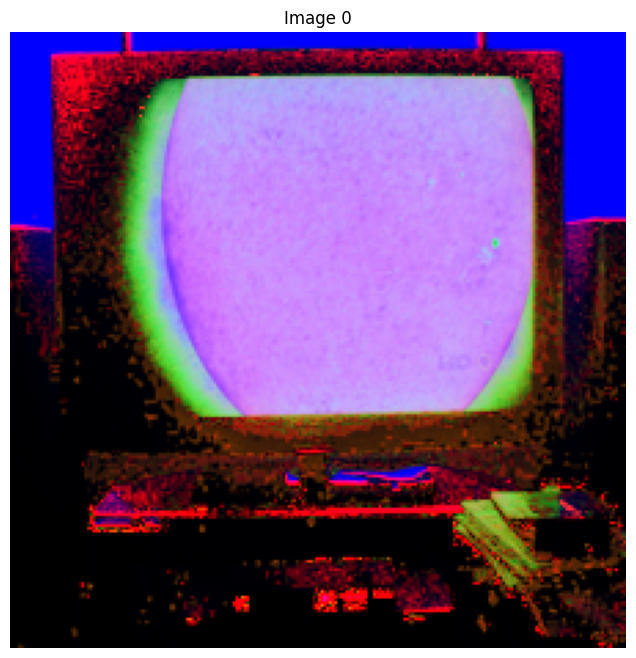

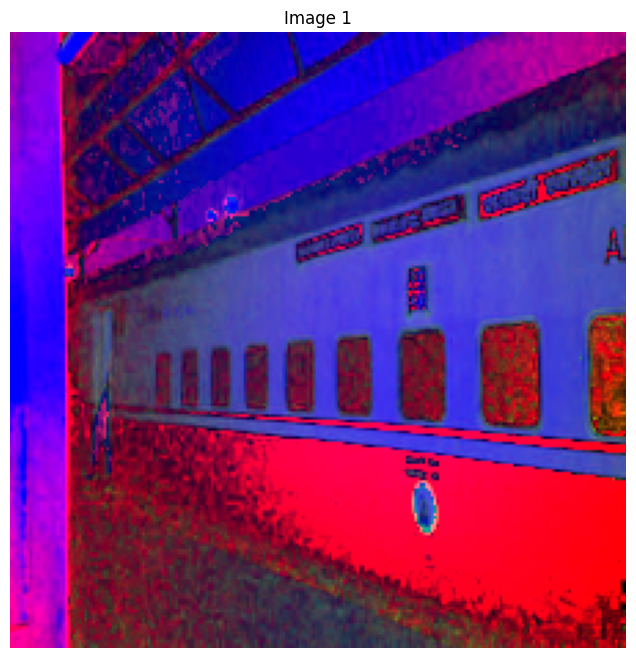

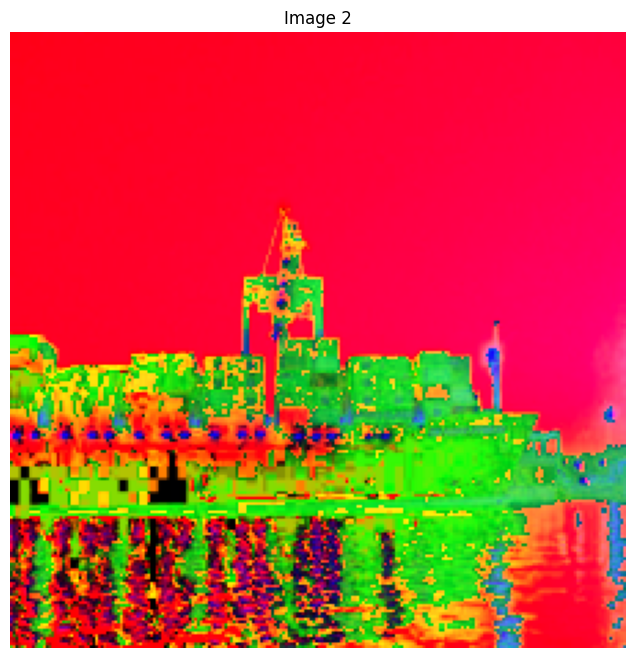

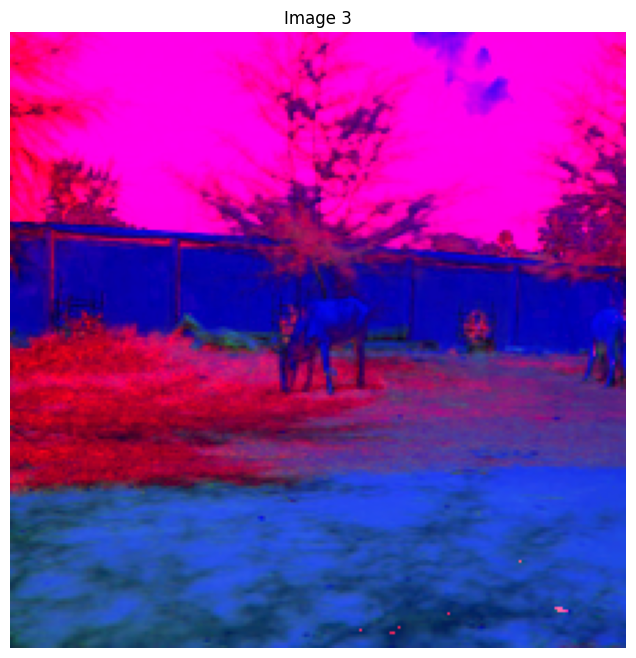

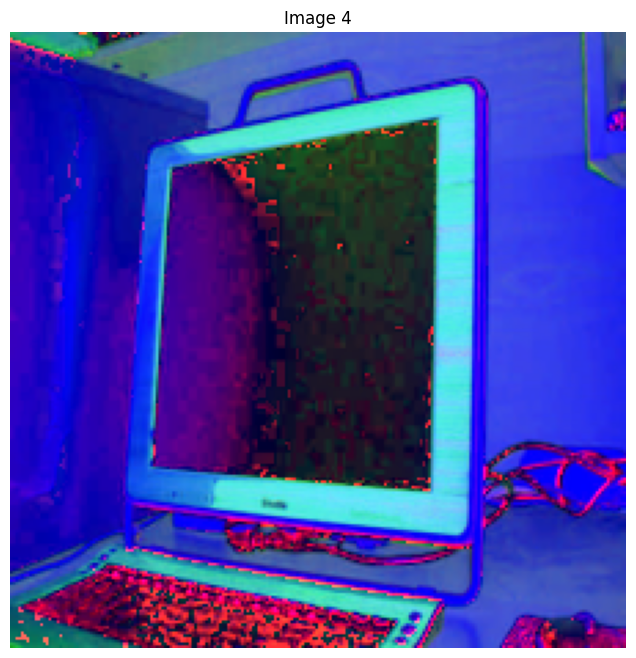

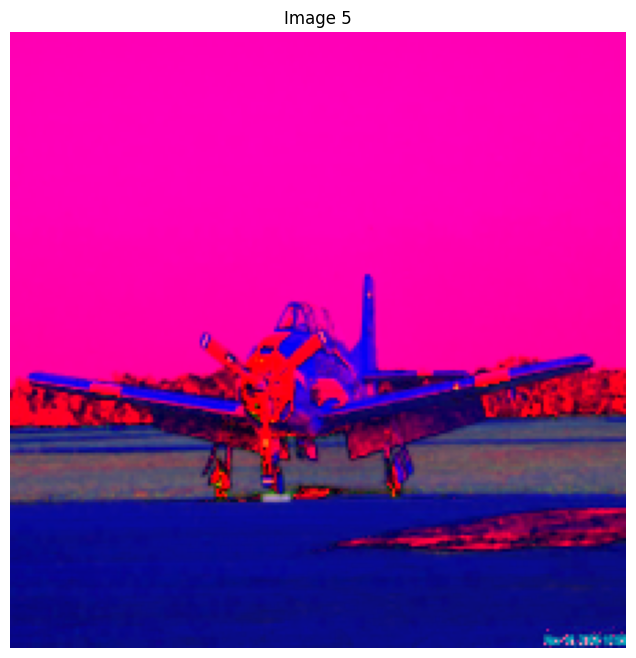

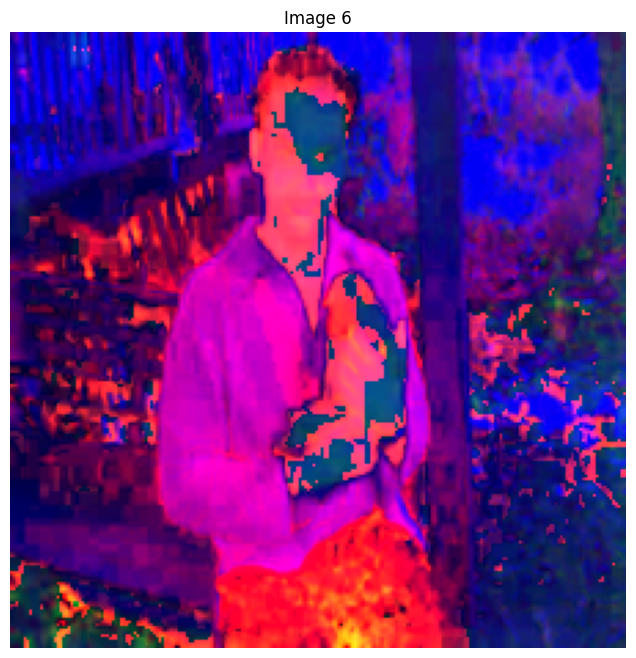

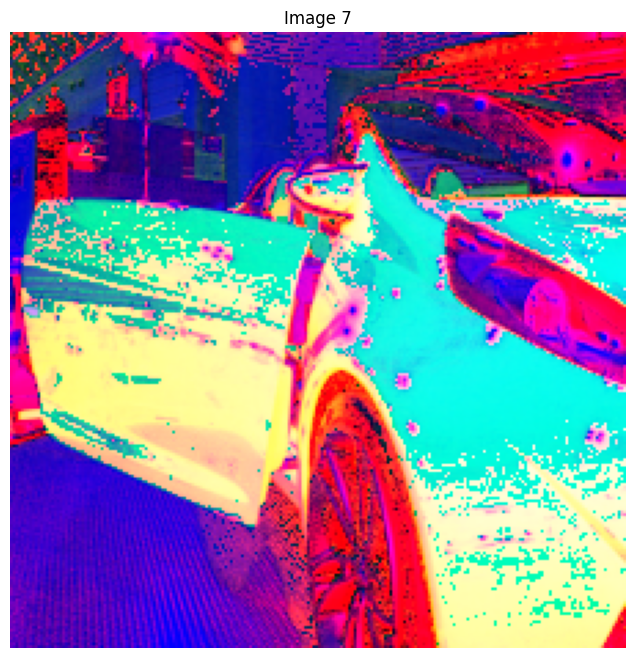

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

def visualize_predictions(model, dataloader, device, S, A, num_classes, conf_threshold=0.00):
    """
    Visualizes predictions on one batch from the dataloader.
    
    Args:
        model (nn.Module): Trained detector.
        dataloader (DataLoader): Validation dataloader.
        device (torch.device): Device.
        S (int): Grid size (e.g., 7 for 7x7).
        A (int): Number of anchors per grid cell.
        num_classes (int): Number of classes.
        conf_threshold (float): Confidence threshold to display a box.
    """
    model.eval()
    with torch.no_grad():
        for images, annotations in dataloader:
            # Move images to device.
            images = images.to(device)
            # Get model predictions.
            bbox_pred, obj_pred, cls_pred = model(images)
            # Decode predictions using our decoder.
            batch_boxes = decode_detector_output(bbox_pred, obj_pred, cls_pred, S, A, num_classes, conf_threshold)
            
            # Loop through the batch.
            for idx in range(images.size(0)):
                # Convert the input tensor back to a displayable image.
                # Our images are complex; take the real part.
                img_tensor = images[idx]
                if img_tensor.is_complex():
                    img_tensor = img_tensor.real
                # Our tensor is in shape (C, H, W); convert to (H, W, C)
                img_np = img_tensor.cpu().permute(1, 2, 0).numpy()
                # Normalize to [0,255] for display (assuming tensor is in [0,1])
                img_np = np.clip(img_np * 255, 0, 255).astype(np.uint8)
                
                # Draw predicted boxes.
                for box in batch_boxes[idx]:
                    x1, y1, x2, y2, score, cls_id = box
                    # Convert normalized coordinates (0,1) to pixel coordinates 
                    x1 = int(x1 * 224)
                    y1 = int(y1 * 224)
                    x2 = int(x2 * 224)
                    y2 = int(y2 * 224)
                    label = VOC_CLASSES_INV.get(cls_id, "unknown")
                    cv2.rectangle(img_np, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(img_np, f"{label}:{score:.2f}", (x1, y1 - 5),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                
                
                plt.figure(figsize=(8, 8))
                plt.imshow(img_np)
                plt.title(f"Image {idx}")
                plt.axis("off")
                plt.show()
            
           
            break


visualize_predictions(detector, val_loader, device, S=7, A=num_anchors, num_classes=num_classes, conf_threshold=0.5)


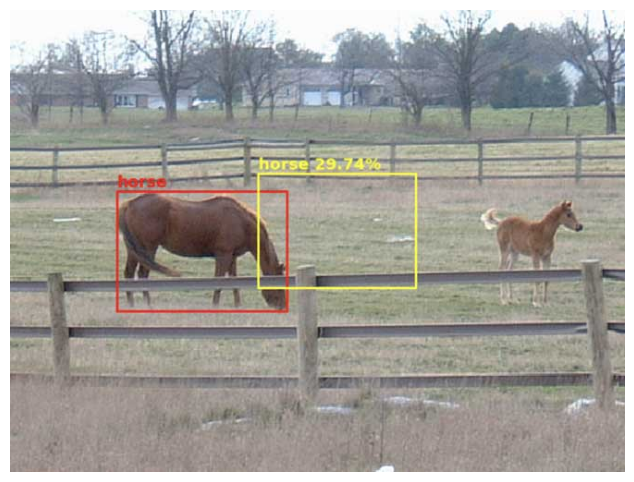

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as transforms


VOC_CLASSES = {
    'aeroplane': 0,
    'bicycle': 1,
    'bird': 2,
    'boat': 3,
    'bottle': 4,
    'bus': 5,
    'car': 6,
    'cat': 7,
    'chair': 8,
    'cow': 9,
    'diningtable': 10,
    'dog': 11,
    'horse': 12,
    'motorbike': 13,
    'person': 14,
    'pottedplant': 15,
    'sheep': 16,
    'sofa': 17,
    'train': 18,
    'tvmonitor': 19
}

# Reverse mapping from class index to class name
VOC_CLASSES_INV = {v: k for k, v in VOC_CLASSES.items()}

def detect_and_display(image_path, model, device, grid_size=7, image_size=224, num_boxes=3, num_classes=20, conf_threshold=0.0):
    """
    Runs inference on a single image using the trained detector and displays the image with bounding boxes.
    
    Args:
        image_path (str): Path to the input image.
        model (torch.nn.Module): Trained complex detector.
        device (torch.device): Device (CPU or GPU).
        grid_size (int): Grid size (default 7 for 7x7 grid).
        image_size (int): Input image size (default 224).
        num_boxes (int): Number of anchors per grid cell.
        num_classes (int): Number of object classes.
        conf_threshold (float): Confidence threshold to draw a bounding box.
    """
    # Load image with OpenCV and convert to RGB
    orig_img = cv2.imread(image_path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    h_orig, w_orig, _ = orig_img.shape
    
    # Convert image to PIL so that transforms work properly.
    pil_img = Image.fromarray(orig_img)
    
    # Define transforms 
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        ToHSV(),
        ToComplex()
    ])
    
    # Preprocess the image
    image_tensor = transform(pil_img).unsqueeze(0).to(device)
    
   
    if not image_tensor.is_complex():
        image_tensor = image_tensor.to(torch.cfloat)
    
    # Set model to eval mode
    model.eval()
    
    # Run the model
    with torch.no_grad():
        bbox_pred, obj_pred, cls_pred = model(image_tensor)
    
    # Convert predictions to CPU numpy arrays for processing
    # For bbox_pred: shape (1, B*4, S, S), we assume B=num_boxes.
    bbox_pred = bbox_pred.cpu()
    obj_pred = obj_pred.cpu()
    cls_pred = cls_pred.cpu()
    
    # Reshape bbox_pred to (B, 4, S, S)
    B = num_boxes
    S = grid_size
    bbox_pred = bbox_pred.view(B, 4, S, S)
    
    # For each grid cell, check objectness for each anchor.
    boxes = []
    labels = []
    scores = []
    
    # The predictions are normalized in [0,1]. To convert them to pixel coordinates, multiply by image_size.
    for i in range(S):
        for j in range(S):
            for b in range(B):
                # Get objectness score for this anchor in grid cell (i,j)
                conf_logit = obj_pred[0, b, i, j]
                conf = torch.sigmoid(conf_logit).item()
                if conf > conf_threshold:
                    # Get bbox prediction for this anchor:
                    # bbox_pred is complex. We use its real part as [x, y, w, h] in normalized format.
                    pred_box = bbox_pred[b, :, i, j].real  # shape (4,)
                    # predicted values: x_center, y_center, w, h (all normalized)
                    x_center = pred_box[0].item()
                    y_center = pred_box[1].item()
                    w_box = pred_box[2].item()
                    h_box = pred_box[3].item()
                    
                    # Convert grid cell offset to absolute normalized coordinates:
                    cell_size = 1.0 / S
                    # Each grid cell's top-left corner in normalized coordinates:
                    cell_x = j * cell_size
                    cell_y = i * cell_size
                    # the network predicts offsets within the cell (in [0,1])
                    abs_x_center = cell_x + x_center * cell_size
                    abs_y_center = cell_y + y_center * cell_size
                    
                    # Convert normalized coordinates to pixel coordinates (for the input image size)
                    abs_x_center *= image_size
                    abs_y_center *= image_size
                    abs_w_box = w_box * image_size
                    abs_h_box = h_box * image_size
                    
                    # Convert center format to corner format:
                    x1 = int(abs_x_center - abs_w_box / 2)
                    y1 = int(abs_y_center - abs_h_box / 2)
                    x2 = int(abs_x_center + abs_w_box / 2)
                    y2 = int(abs_y_center + abs_h_box / 2)
                    
                    boxes.append([x1, y1, x2, y2])
                    
                    # For class prediction, take the predicted class for this anchor.
                    # cls_pred is real and shaped (1, B*num_classes, S, S). Reshape to (B, num_classes, S, S).
                    cls_pred_reshaped = cls_pred.view(B, num_classes, S, S)
                    # For anchor b at grid cell (i,j):
                    cls_scores = cls_pred_reshaped[b, :, i, j]
                    # Get predicted class index:
                    class_idx = torch.argmax(cls_scores).item()
                    labels.append(VOC_CLASSES_INV.get(class_idx, "unknown"))
                    scores.append(conf)
                    
    # Draw boxes on the original image.
    out_img = orig_img.copy()
    for box, label, score in zip(boxes, labels, scores):
        x1, y1, x2, y2 = box
        cv2.rectangle(out_img, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(out_img, f"{label}:{score:.2f}", (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(out_img)
    plt.axis("off")
    plt.show()

# Example usage:
detect_and_display("/kaggle/input/horsepic/localization-1box-bad2x.jpg", detector, device, grid_size=7, image_size=224, num_boxes=num_anchors, num_classes=num_classes, conf_threshold=0.0)

